In [1]:
import numpy as np
import matplotlib.pyplot as plt

from module.tools import make_samples
from module.ntbk2_routines import *
from module.multivariate import MultivariateEnKF1D, MultivariatePKF1D

from sympy import Function, Derivative, Eq, symbols
from sympkf import Expectation, PDESystem, SymbolicPKF, FDModelBuilder, t
import sympy
sympy.init_printing()

# 1. The advection problem <a class="anchor" id="section1"></a>

We consider the following 1D advection problem : 

$$
\partial_t \mathcal{X} + u \partial_x \mathcal{X}= -\mathcal{X}\partial_x u
$$

where $u$ is a wind field. The term on the right hand of the equation implies a conservation of mass of the tracer $A$.

We will consider periodic boundary conditions.


An RK4 time-scheme is used.

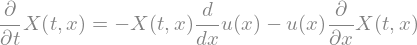

In [2]:
x = symbols('x')
u = Function('u')(x)
X = Function('X')(t,x)

# definition of the dynamics
dynamics = [Eq(Derivative(X,t), -u*Derivative(X,x) -X*Derivative(u,x)),]
dynamics[0]

## Deriving the PKF dynamics with SymPKF

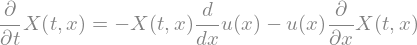

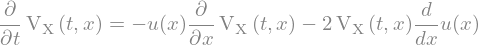

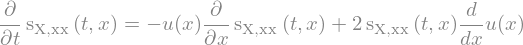

In [3]:
pkf_dynamics = SymbolicPKF(dynamics)

for equation in pkf_dynamics.in_aspect:    
    display(equation)

## Automatic code generation for building classes

In [4]:
Nx=241

exec(FDModelBuilder(dynamics, class_name='adv').code)
exec(FDModelBuilder(pkf_dynamics.in_aspect, class_name='pkf_adv').code)

#saving generated classes :
FDModelBuilder(dynamics, class_name='adv').write_module()
FDModelBuilder(pkf_dynamics.in_aspect, class_name='pkf_adv').write_module()

class adv has been written in module adv in file adv.py
class pkf_adv has been written in module pkf_adv in file pkf_adv.py


In [5]:
class EnKF_Advection(MultivariateEnKF1D, adv):
    def __init__(self, shape):
        adv.__init__(self, shape)
        MultivariateEnKF1D.__init__(self, ['X'])
    
class PKF_Advection(MultivariatePKF1D, pkf_adv):
    def __init__(self, shape):
        pkf_adv.__init__(self, shape)
        MultivariatePKF1D.__init__(self, ['X'])

In [6]:
enkf_lr = EnKF_Advection(shape=(Nx,))
enkf_hr = EnKF_Advection(shape=(3*Nx,))
pkf = PKF_Advection(shape=(Nx,))

domain = pkf

# 2. Forecasting EnKF and PKF <a class="anchor" id="section2"></a>

#### wind conditions

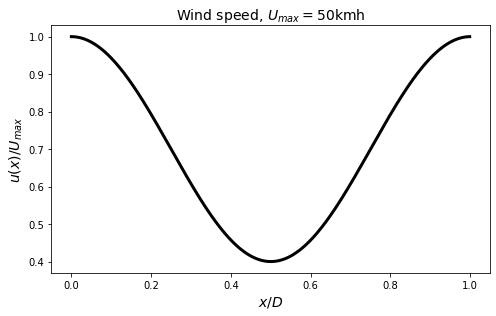

In [7]:
D = 1000  #km
u_amp = 15 #kmh
u_mean = 35  #kmh

u_lr = (u_mean + u_amp*np.cos(2*np.pi*enkf_lr.x[0]))/D
u_hr = (u_mean + u_amp*np.cos(2*np.pi*enkf_hr.x[0]))/D

Tadv = 1/u_lr.mean()

enkf_lr.u = u_lr
enkf_hr.u = u_hr
pkf.u = u_lr

fig,ax = plt.subplots(1,1,figsize=(7,4.5))
ax.plot(enkf_hr.x[0], u_hr/u_hr.max(), c='k',linewidth=3)
ax.set_xlabel(r'$x/D$',fontsize=14)
ax.set_title(r"Wind speed, $U_{max}=$50kmh",fontsize=14)
ax.set_ylabel(r"$u(x)/U_{max}$",fontsize=14);
fig.tight_layout()
fig.savefig(f'../figures/Nx{Nx}/wind_Nx{Nx}.png')

#### initial conditions

In [8]:
x0 = 1
sigma0 = 0.1
lh0 = 15*enkf_lr.dx[0]

#### initializing filters

In [9]:
ensemble_size = 6400

# generating initial ensemble :
ensemble_state0_lr = x0 + make_samples(ensemble_size, domain.x[0], lh0)[:,np.newaxis,:] * sigma0
ensemble_state0_hr = x0 + make_samples(ensemble_size, enkf_hr.x[0], lh0)[:,np.newaxis,:] * sigma0
pkf_state0 =(np.array([x0,sigma0**2,lh0**2]) + np.zeros(Nx)[:,np.newaxis]).T

#### Forecasting

In [10]:
dt = domain.dx[0]/u_lr.max() #CFL condition
enkf_lr.set_dt(dt)
pkf.set_dt(dt)

dt_hr = enkf_hr.dx[0]/u_hr.max()
enkf_hr.set_dt(dt_hr)

times = enkf_lr.window(3.0*Tadv, start=0)
times_hr = list(enkf_hr.window(3.0*Tadv,start=0))
times_hr.append(times[-1])
times_hr = np.sort(times_hr)

saved_times = list(times[::10]) + [times[-1]]

In [11]:
#low resolution ensemble forecast:
traj_enkf_lr = enkf_lr.ensemble_forecast(times, ensemble_state0_lr, saved_times)
diag_enkf_lr = enkf_lr.diagnosis(traj_enkf_lr, [Nx//2],['X'])

In [ ]:
#high resolution ensemble forecast:
traj_enkf_hr = enkf_hr.ensemble_forecast(times_hr, ensemble_state0_hr, saved_times)
diag_enkf_hr = enkf_hr.diagnosis(traj_enkf_hr, [(3*Nx)//2],['X'])

In [ ]:
#pkf forecast:
traj_pkf = pkf.forecast(times, pkf_state0, saved_times)
rendered_traj_pkf = pkf.render_traj(traj_pkf, [Nx//2],['X'])

## 2.3 Comparing results : <a class="anchor" id="section2.3"></a>

In [ ]:
times = np.array(list(rendered_traj_pkf.keys()))
stops = np.linspace(0,len(times)-1,6).astype(int)
normalizations = [x0,sigma0,lh0]
fig = univariate_plot(times[stops], domain.x[0], diag_enkf_lr, rendered_traj_pkf, normalizations,
                      ensemble_size, fr'{ensemble_size}-Ensemble; $N_x=${Nx}',c='dodgerblue',ls='dashdot');
fig.savefig(f'../figures/Nx{Nx}/advection_diagnosis_ensemble_vs_pkf_Nx{Nx}.png')

In [ ]:
stops = np.linspace(0,len(saved_times)-1,6).astype(int)
normalizations = [x0,sigma0,lh0]
fig = univariate_plot_bis(
                      np.array(saved_times)[stops],
                      enkf_hr.x[0], pkf.x[0],
                      diag_enkf_hr, rendered_traj_pkf,
                      normalizations,ensemble_size)
fig.savefig('../figures/advection_diagnosis_ensemble_highres_vs_pkf_lowres.png')

# 3. Introducing the univariate covariance model : <a class="anchor" id="section3"></a>

## 3.1 The PKF autocorrelation function model : <a class="anchor" id="section3.1"></a>

For the univariate case, the model use to describe correlation functions results from the theorem 1 of Paciorek and Schervish (2004), which states that for any homogeneous correlation $\rho^h(||\mathbf{x}-\mathbf{y}||)$ in $\mathbb{R}^d$ of aspect-tensor $\mathbf{I}_d$ and any differential field of symmetric definite positive tensor $\mathbf{s}$, it is possible to form a heterogeneous correlation function $\rho$ defined by :
\begin{equation}
\label{eq:paciorek}
\rho(\mathbf{s})(\mathbf{x},\mathbf{y}) = 
\frac{|\mathbf{s_x}|^{1/4} |\mathbf{s_y}|^{1/4} }
{|\frac{1}{2} (\mathbf{s_x} + \mathbf{s_y})|^{1/2}} 
\rho^h \left( 
||\mathbf{x}-\mathbf{y}||_{[\frac{1}{2}(\mathbf{s_x}+\mathbf{s_y})]^{-1}}
\right)
\end{equation}

for which the aspect tensor at $\mathbf{x}$ is approximately $\mathbf{s_x}$, and where $|\cdot|$ stands for the matrix determinant. The homogeneous correlation function that we consider is gaussian, leading to the heterogeneous gaussian univariate covariance model :

\begin{equation}
\label{eq:heterogeneous_gaussian_cov_model}
\mathbf{P}^{\texttt{he.gauss} }(V,\mathbf{s})(\mathbf{x},\mathbf{y}) = 
\sqrt{ V_{\mathbf{x}} V_{\mathbf{y}}}
\frac{|\mathbf{s_x}|^{1/4} |\mathbf{s_y}|^{1/4} }
{|\frac{1}{2} (\mathbf{s_x} + \mathbf{s_y})|^{1/2}} 
\exp \left( 
-\frac{1}{2}||\mathbf{x}-\mathbf{y}||^2_{[\frac{1}{2}(\mathbf{s_x}+\mathbf{s_y})]^{-1}}
\right)
\end{equation}


In [ ]:
zoom_factor = 5
zoom_lr = np.arange(Nx//2 - Nx//zoom_factor,Nx//2 + Nx//zoom_factor,1)
zoom_hr = np.arange((3*Nx)//2 - (3*Nx)//zoom_factor,(3*Nx)//2 + (3*Nx)//zoom_factor,1)

times_plot = np.round(np.linspace(0,3,6),2)
fig, ax = plt.subplots(2,3,figsize=(16,9))
fig.suptitle(r"Auto-correlation functions at $x=0.5$",fontsize=15)
stops  = np.linspace(0,len(saved_times)-1,6).astype(int)

xx_lr = np.linspace(-.5,.5,Nx); loc_lr = Nx//2
xx_hr = np.linspace(-.5,.5,(3*Nx)); loc_hr = (3*Nx)//2

panels_index = [f'({c}) ' for c in 'abcdef']
for i, t in enumerate(np.array(saved_times)[stops]):
    empirical_correlation_func_lr = diag_enkf_lr[t]['Correlation functions'][loc_lr]['X/X']
    empirical_correlation_func_hr = diag_enkf_hr[t]['Correlation functions'][loc_hr]['X/X']
    pkf_cor_func = rendered_traj_pkf[t]['Correlation functions'][loc_lr]['X/X']
    
    ax.flat[i].plot(xx_hr[zoom_hr],empirical_correlation_func_hr[zoom_hr],label=fr'Ensemble; $N_x=${(3*Nx)}',c='b',linestyle='--',zorder=3)
    ax.flat[i].plot(xx_lr[zoom_lr],empirical_correlation_func_lr[zoom_lr],label=fr'Ensemble; $N_x=${Nx}',c='dodgerblue',linestyle='dashdot',zorder=3)
    ax.flat[i].plot(xx_lr[zoom_lr],pkf_cor_func[zoom_lr],label=fr'PKF; $N_x=${Nx}',c='r',lw=1)
    
    ax.flat[i].grid(alpha=0.5);    ax.flat[i].axvline(0,linestyle='--',c='grey')
    ax.flat[i].set_title(panels_index[i]+f"$t$={times_plot[i]}" +r"$\tau_{adv}$",fontsize=17) ;ax.flat[i].set_ylim(-.1,1.1)
    if i>2 : ax.flat[i].set_xlabel(r"$\delta x /D$",fontsize=13)
    if i == 0 or i==3 : ax.flat[i].set_ylabel(r'$\rho(x_l,x_l + \delta x)$',fontsize=13)
    if i == 0 : ax.flat[i].legend();
        
fig.tight_layout();
fig.savefig(f'../figures/advection_autocorrelation_functions_pkf_lowres_enkf_highres.png')

This auto-correlation model seems to reproduce accuratly the true behaviour of the observed auto-correlation functions.